In [106]:
import tsplib95 
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np




In [107]:
problema = tsplib95.load("test30.tsp")

TWICE AROUND THE TREE

In [105]:
def euclidean_distance(coord1, coord2):
    return math.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(coord1, coord2)))


def create_graph(problem):
    G = nx.Graph()
    for node1 in problem.get_nodes():
        for node2 in problem.get_nodes():
            if node1 != node2:
                coord1 = problem.node_coords[node1]
                coord2 = problem.node_coords[node2]
                distance = euclidean_distance(coord1, coord2)
                G.add_edge(node1, node2, weight=distance)
    return G

def findPathWeight(A, path):
    weight = 0
    for i in range(len(path) - 1):
        weight += A[path[i]][path[i + 1]]['weight']
    return weight


def twiceAroundTheTreeTSP(problem):
    G = create_graph(problem)

    # Calculando a Árvore Geradora Mínima
    MST = nx.minimum_spanning_tree(G)

    # Encontrando o primeiro nó no grafo
    first_node = list(G.nodes)[0]

    # Executando o DFS para obter o percurso
    path = list(nx.dfs_preorder_nodes(MST, first_node))
    path.append(path[0])

    # Calculando o peso do caminho
    weight = findPathWeight(G, path)
    return weight, path
# Exemplo de uso
weight, path = twiceAroundTheTreeTSP(problema)
print("Peso do caminho:", weight)
print("Caminho:", path)

Peso do caminho: 640.9012229251007
Caminho: [1, 32, 11, 38, 5, 9, 50, 16, 2, 34, 30, 21, 29, 49, 10, 39, 22, 27, 51, 46, 12, 47, 4, 17, 37, 15, 44, 42, 19, 41, 13, 40, 45, 33, 18, 48, 6, 14, 25, 8, 26, 31, 28, 3, 20, 35, 36, 23, 7, 43, 24, 1]


CHRISTOFIDES

In [96]:
def findShortcutPath(A):
    path = list(nx.eulerian_circuit(A, source=list(A.nodes)[0]))
    path = [x[0] for x in path]
    shortcutPath = list(dict.fromkeys(path))
    return shortcutPath + [shortcutPath[0]]

# Algoritmo de Christofides
def christofidesTSP(problema):

    G = create_graph(problema)
    MST = nx.minimum_spanning_tree(G)
    degrees = dict(nx.degree(MST))
    oddNodes = [node for node, degree in degrees.items() if degree % 2 == 1]
    oddNodesSubgraph = G.subgraph(oddNodes)
    matching = list(nx.min_weight_matching(oddNodesSubgraph, maxcardinality=True))

    MSTMultiGraph = nx.MultiGraph(MST)
    for node1, node2 in matching:
        MSTMultiGraph.add_edge(node1, node2, weight=G[node1][node2]['weight'])

    path = findShortcutPath(MSTMultiGraph)
    weight = findPathWeight(G, path)
    return weight, path


# Exemplo de uso
weight, path = christofidesTSP(problema)
print("Peso do caminho:", weight)
print("Caminho:", path)

Peso do caminho: 2900.5084584334763
Caminho: [1, 5, 6, 4, 9, 10, 8, 3, 7, 2, 1]


In [108]:
class Node:
    def __init__(self, bound, boundEdges, cost, solution):
        self.bound = bound
        self.boundEdges = boundEdges
        self.cost = cost
        self.solution = solution
    
    def __lt__(self, other):
        if len(self.solution) == len(other.solution):
            return self.bound < other.bound
        return len(self.solution) > len(other.solution)
    def __repr__(self) -> str:
        return f"Node({self.bound}, {self.boundEdges}, {self.cost}, {self.solution})"

def findTwoMinimalEdges(list):
    min1 = np.inf
    min2 = np.inf
    for j in list:
        if list[j]['weight'] < min1:
            min2 = min1
            min1 = list[j]['weight']
        elif list[j]['weight'] < min2:
            min2 = list[j]['weight']
    return min1, min2

def findInitialBound(A):
    bound = 0
    initialBoundEdges = np.zeros((A.number_of_nodes(), 2), dtype=list)
    for i in range(A.number_of_nodes()):
        min1, min2 = findTwoMinimalEdges(A[i])
        initialBoundEdges[i][0] = min1
        initialBoundEdges[i][1] = min2
        bound += min1 + min2
    return bound / 2, initialBoundEdges

def findBound(A, solution, boundEdges, bound):
    changedEdges = np.zeros(A.number_of_nodes(), dtype=int)
    newEdges = np.array(boundEdges)
    edgeWeight = A[solution[-2]][solution[-1]]['weight']
    sum = bound * 2
    if newEdges[solution[-2]][0] != edgeWeight:
        if changedEdges[solution[-2]] == 0:
            sum -= newEdges[solution[-2]][1]
            sum += edgeWeight
        else:
            sum -= newEdges[solution[-2]][0]
            sum += edgeWeight
        changedEdges[solution[-2]] += 1
    if newEdges[solution[-1]][0] != edgeWeight:
        if changedEdges[solution[-1]] == 0:
            sum -= newEdges[solution[-1]][1]
            sum += edgeWeight
        else:
            sum -= newEdges[solution[-1]][0]
            sum += edgeWeight
        changedEdges[solution[-1]] += 1
    return sum / 2, newEdges 
from heapq import heappush, heappop

def branchAndBoundTSP(A):

    initialBound, initialBoundEdges = findInitialBound(A)
    root = Node(initialBound, initialBoundEdges, 0, [0])
    heap = []
    heappush(heap, root)
    best = np.inf
    solution = []
    nodeCount = 0
    while heap:
        node = heappop(heap)
        nodeCount += 1
        level = len(node.solution)
        if level > A.number_of_nodes():
            if best > node.cost:
                best = node.cost
                solution = node.solution
        else:
            if node.bound < best:
                if level < A.number_of_nodes() - 2:
                    for k in range(1, A.number_of_nodes()):
                        if k == node.solution[-1] or k == 0:
                            continue
                        edgeWeight = A[node.solution[-1]][k]['weight']
                        newBound, newEdges = findBound(A, node.solution + [k], node.boundEdges, node.bound) 
                        if k not in node.solution and newBound < best:
                            newNode = Node(newBound, newEdges, node.cost + edgeWeight, node.solution + [k])
                            if k == 2:
                                if 1 not in node.solution:  
                                    continue 
                            heappush(heap, newNode)
                else:
                    for k in range(1, A.number_of_nodes()):
                        if k == node.solution[-1] or k == 0:
                            continue
                        lastNode = 0
                        for i in range(1, A.number_of_nodes()):
                            if i not in node.solution + [k] and k != i:
                                lastNode = i
                                break
                        edgeWeight = A[node.solution[-1]][k]['weight']
                        nextEdgeWeight = A[k][lastNode]['weight']
                        lastEdgeWeight = A[lastNode][0]['weight']
                        cost = node.cost + edgeWeight + nextEdgeWeight + lastEdgeWeight
                        if k not in node.solution and cost < best:
                            newNode = Node(cost, [], cost, node.solution + [k, lastNode, 0])
                            heappush(heap, newNode)
    #add 1 to each element in solution
    solution = [x + 1 for x in solution]
    return best, solution



In [98]:
def drawGraph(A):
    layout = nx.spring_layout(A)
    nx.draw(A, layout)
    nx.draw_networkx_edge_labels(A, pos=layout, edge_labels=nx.get_edge_attributes(A, 'weight'))
    labels = {i: i for i in range(len(A))}
    nx.draw_networkx_labels(A, pos=layout, labels=labels)
    plt.show()




In [109]:


def create_graph(problem):
    G = nx.Graph()
    for node1 in problem.get_nodes():
        for node2 in problem.get_nodes():
            if node1 != node2:
                # Ajustando os índices dos nós para começar de 0
                coord1 = problem.node_coords[node1]
                coord2 = problem.node_coords[node2]
                distance = euclidean_distance(coord1, coord2)
                G.add_edge(node1 - 1, node2 - 1, weight=distance)
    return G

G = create_graph(problema)
# Exemplo de uso
weight, path = branchAndBoundTSP(G)
print("Peso do caminho:", weight)
print("Caminho:", path)

KeyboardInterrupt: 

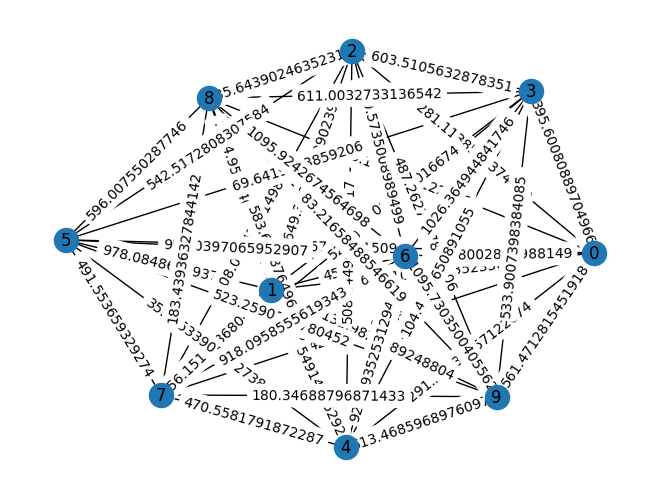

In [100]:
drawGraph(G)